In [1]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 5.7 kB/s  eta 0:00:01    |████▍                           | 97.1 MB 212 kB/s eta 0:47:38     |███████████████████████▊        | 521.0 MB 10.1 MB/s eta 0:00:19
     |████████████████████████████████| 6.6 MB 187 kB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1
    Uninstalling torchvision-0.11.1:
      Successfully uninstalled torchvision-0.11.1


In [2]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.5 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 750 kB 191 kB/s eta 0:00:01
     |████████████████████████████████| 407 kB 3.6 MB/s eta 0:00:01
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=c8ba3e49c57b44fcc7ef575269d6ed052d016e29180d2de261d14fc0b9367c59
  Stored in directory: /home/pratzz/.cache/pip/wheels/c1/be/e9/b90ded2a496c975a539af002fe1f0f2a22a97af13b41866d6e
Successfully built torch-geometric


In [3]:
! pip install energyflow

     |████████████████████████████████| 700 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 430 kB 10.8 MB/s eta 0:00:01


In [1]:
import energyflow

In [2]:
samples = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',
                        with_bc=False, cache_dir='~/.energyflow')

### Data Preprocessing

In [3]:
import numpy as np
import pandas as pd

In [8]:
print(len(samples[0]))

100000


In [9]:
print(samples[1])

[1. 1. 1. ... 1. 0. 0.]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

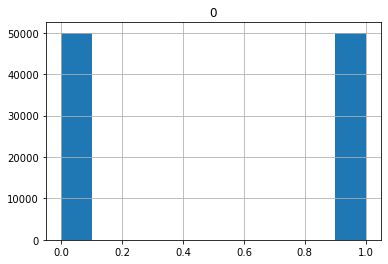

In [10]:
y = pd.DataFrame(samples[1])
y.hist()

In [12]:
X=[]
for i in samples[0]:
    X.append(i[0])
X=pd.DataFrame(X,columns=["pt","eta","azimuthal","pgdid"])
y=pd.DataFrame(samples[1],columns=["Y"])
X["y"]=y

X.head(10)

,pt,eta,azimuthal,pgdid,y
0,0.268769,0.356903,4.741387,22.0,1.0
1,1.212663,-0.112853,3.047088,-211.0,1.0
2,0.216829,-0.997057,0.532569,22.0,1.0
3,0.413806,0.956889,5.742566,211.0,1.0
4,0.476434,-0.403307,4.126747,22.0,1.0
5,7.702450,-0.819775,5.794888,321.0,0.0
6,0.235739,-1.094473,5.626174,211.0,1.0
7,0.317746,0.245092,1.284100,211.0,1.0
8,0.879651,0.109774,3.468267,211.0,1.0
9,0.160245,-1.455975,3.670505,22.0,1.0


<AxesSubplot:>

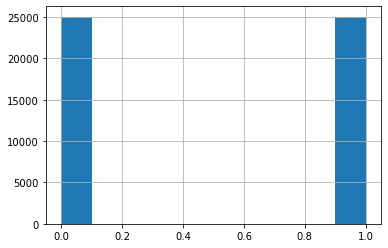

In [14]:
X = X[:50000]
y = X["y"]
X = X.drop(["y"], axis=1)
y.hist()

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [16]:
print(len(X_train))

35000


Evidently, the dataset is unbiased, given that the distribution for quarks and gluons is almost similar. Here, I consider only a part of the data as all-to-all connected graph flows out of memory for all the dataset

### Deep Graph Library

In [18]:
! pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 273.2 kB/s eta 0:00:00m eta 0:00:010:00:01


In [19]:
import dgl
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import networkx as nx

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Adding nodes and edges:

In [20]:
def build_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(len(X))
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    return g

In [21]:
edge_list=[]
from itertools import combinations  
import random
edges=random.sample(range(1, len(X_train)), int(len(X_train)/30))
edge_list=combinations(edges,2)

In [22]:
edge_list=list(edge_list)

In [23]:
print(len(edge_list))

679195


In [24]:
G = build_graph(edge_list)

/home/pratzz/anaconda3/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [25]:
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 50000 nodes.
We have 1358390 edges.


In [45]:
import torch.nn as nn
import torch.nn.functional as F
def gcn_message(edges):
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        g.ndata['h'] = inputs
        g.send_and_recv(g.edges(), gcn_message, gcn_reduce)
#         g.recv(g.nodes(), gcn_reduce)
        h = g.ndata.pop('h')
        return self.linear(h)

In [46]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        h = self.softmax(h)
        return h
net = GCN(4, 10, 2)

In [47]:
inputs = torch.tensor(X.values)#torch.eye(node_count)
labeled_nodes = torch.tensor(y_train[::3].index)
labels = torch.tensor(y_train[::3].values)

In [48]:
print(max(y_train[::3].keys()),len(labels))

49997 11667


In [49]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
all_preds = []
epochs = 10
losses=[]
for epoch in range(epochs):
    preds = net(G, inputs.float())
    all_preds.append(preds)
    # we only compute loss for labeled nodes
    print(len(preds),len(labels))
    loss = F.cross_entropy(preds[labeled_nodes], labels.long())
    losses.append(loss)
    optimizer.zero_grad() # PyTorch accumulates gradients by default
    loss.backward() 
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

/tmp/ipykernel_137909/507448650.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  h = self.softmax(h)


50000 11667
Epoch 0 | Loss: 0.8137
50000 11667
Epoch 1 | Loss: 0.7402
50000 11667
Epoch 2 | Loss: 0.8069
50000 11667
Epoch 3 | Loss: 0.8133
50000 11667
Epoch 4 | Loss: 0.8126
50000 11667
Epoch 5 | Loss: 0.8125
50000 11667
Epoch 6 | Loss: 0.8098
50000 11667
Epoch 7 | Loss: 0.7951
50000 11667
Epoch 8 | Loss: 0.7690
50000 11667
Epoch 9 | Loss: 0.7826


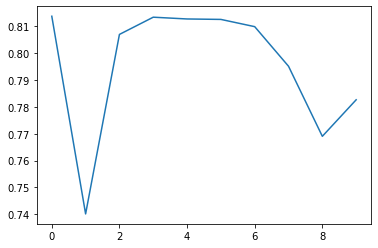

In [50]:
import matplotlib.pyplot as plt
plt.plot(range(epochs),losses)
plt.show()

In [51]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'g', 'p')

print(predicted_class)
print(color)

[0 0 0 ... 0 0 0]
['g' 'g' 'g' ... 'g' 'g' 'g']


In [52]:
print(len(predicted_class),len(y))

50000 50000


In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted_class,y)

0.49952